In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
%matplotlib inline
test_path = 'https://media.githubusercontent.com/media/cchopade/gahack2/master/test.csv'
train_path = 'https://media.githubusercontent.com/media/cchopade/gahack2/master/train.csv'
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(train_path)
df.Datetime = pd.to_datetime(df.Datetime)
df = df.set_index(['Item_ID','Datetime'])
df.drop(labels = 'ID', axis = 1, inplace = True)
df = df.sort_index(ascending=False)
df.sort_values(['Item_ID','Datetime'],ascending=[False,True],inplace=True)
df.reset_index(inplace=True)
df['day'] = df["Datetime"].apply(lambda x: x.day)
df['week'] = df["Datetime"].apply(lambda x: x.week)
df['month'] = df["Datetime"].apply(lambda x: x.month)
df['year'] = df["Datetime"].apply(lambda x: x.year)

df.head()

,Item_ID,Datetime,Category_3,Category_2,Category_1,Price,Number_Of_Sales,day,week,month,year
0,31375,2015-05-27,0,5.0,235,0.882,133,27,22,5,2015
1,31375,2015-05-28,0,5.0,235,0.787,113,28,22,5,2015
2,31375,2015-05-29,0,5.0,235,0.942,59,29,22,5,2015
3,31375,2015-05-30,0,5.0,235,1.049,56,30,22,5,2015
4,31375,2015-05-31,0,5.0,235,1.381,37,31,22,5,2015


In [3]:
df_train = df[(df["year"] == 2014) & (df["month"] <3 )].copy()
df_train.shape

(22790, 11)

In [4]:
items = list(df_train.Item_ID.unique())
len(items)

474

In [5]:
df_test = df[(df["year"] == 2014) & (df["month"] == 3 )].copy()
df_test.shape

(14281, 11)

In [9]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    #print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
def forecast_arima_model(train, test1, arima_order):
    # prepare training dataset
    #train_size = int(len(X) * 0.8)
    #train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    test = [x for x in test1]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print('Forecast RMSE=%0.3F'%(np.sqrt(error)))
    
    l = [l.tolist() for l in predictions]
    pred_list = [item for sublist in l for item in sublist]

    return error, pred_list

In [49]:
%%time
item1_train = df[df.Item_ID == items[0]].copy()
item1_train.set_index(item1_train.Datetime,inplace=True)
item1_train.head()

p = [1,2,4,6,8,10]
q = [1,2]
d = [1,2]

best = evaluate_models(item1_train['Price'],p,d,q)

item1_test = df[df.Item_ID == items[0]].copy()
item1_test.set_index(item1_test.Datetime,inplace=True)
item1_test.head()
forecast_arima_model(item1_train['Price'], item1_test['Price'],best

  0%|          | 0/6 [00:00<?, ?it/s]

ARIMA(1, 1, 1) MSE=0.018


 17%|█▋        | 1/6 [00:36<03:00, 36.07s/it]

ARIMA(2, 1, 1) MSE=0.018


 67%|██████▋   | 4/6 [03:47<01:53, 56.83s/it]

ARIMA(8, 1, 1) MSE=0.018


100%|██████████| 6/6 [25:00<00:00, 250.01s/it]


Best ARIMA(1, 1, 1) MSE=0.018
CPU times: user 1h 43min 27s, sys: 1min 14s, total: 1h 44min 42s
Wall time: 27min 5s


In [52]:
forecast_arima_model(item1_train['Price'], item1_test['Price'],(1,1,1))

Forecast MSE=0.015


0.014892085700741867

Forecast RMSE=55.795


TypeError: 'NoneType' object is not iterable

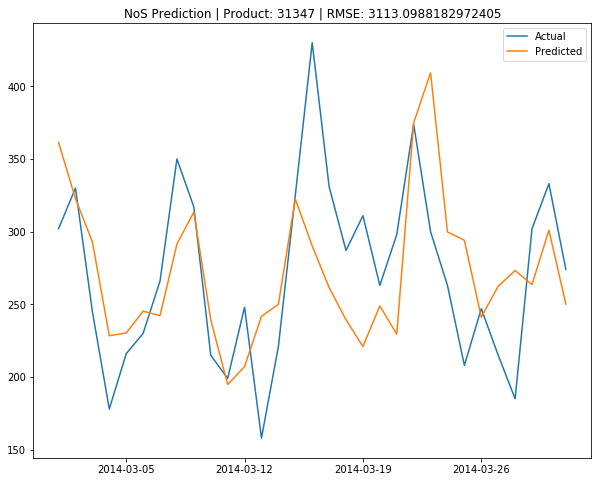

In [26]:
%%time
for i in items[7:10]:
    
    item1_train = df_train[df_train.Item_ID == i]
    item1_train.set_index(item1_train.Datetime,inplace=True)
    item1_train.head()

    p = [1,2,4,6,8,10]
    q = [1,2]
    d = [1,2]

    best = evaluate_models(item1_train['Number_Of_Sales'],p,d,q)

    item1_test = df_test[df_test.Item_ID == i]
    item1_test.set_index(item1_test.Datetime,inplace=True)
    item1_test.head()
    error, pred = forecast_arima_model(item1_train['Number_Of_Sales'], item1_test['Number_Of_Sales'],best)
    item1_test['pred'] = pred

    plt.figure(figsize=(10,8))
    plt.plot(item1_test.index, item1_test.Number_Of_Sales, label = 'Actual')
    plt.plot(item1_test.index, item1_test.pred, label = 'Predicted')
    plt.legend()
    plt.title('NoS Prediction | Product: {} | RMSE: {}'.format(i,error))
    label = str(i)+"_nos.png"                     
    plt.savefig(label)